# Introducción: Comparación de Algoritmos sobre Fashion‑MNIST

Este cuaderno documenta el trabajo práctico de la Unidad 3: comparar el desempeño de redes neuronales frente a algoritmos clásicos de Machine Learning en la clasificación de imágenes del dataset Fashion‑MNIST.

Nota del grupo: en este proyecto de grupo implementaremos únicamente el algoritmo clásico Naive Bayes (GaussianNB); las secciones de KNN, SVM y Random Forest quedan omitidas por alcance del grupo.

Objetivos principales
- Implementar y entrenar Naive Bayes (GaussianNB) y redes neuronales (Dense y CNN).
- Evaluar y comparar métricas (accuracy, precision, recall, F1) y tiempos de entrenamiento/predicción.
- Analizar errores por clase y presentar visualizaciones comparativas.

Dataset
- Fashion‑MNIST: imágenes en escala de grises 28×28, 60.000 muestras de entrenamiento y 10.000 de prueba, 10 clases (Camiseta/Top, Pantalón, Suéter, Vestido, Abrigo, Sandalia, Camisa, Zapatilla, Bolso, Botín).

Estructura del cuaderno
1. Preparación y exploración de datos: carga, visualización, normalización y aplanado para modelos clásicos (Naive Bayes) y redes neuronales.
2. Modelos clásicos: implementación y evaluación de Naive Bayes (GaussianNB) — baseline y mejoras recomendadas.
3. Redes neuronales: red densa y CNN (arquitecturas sugeridas), curvas de entrenamiento y evaluación final.
4. Análisis comparativo: tabla de métricas, análisis por clase y visualizaciones.
5. Conclusiones y recomendaciones.

Entregables y métricas
- Métricas: Accuracy, Precision (macro/micro), Recall (macro/micro), F1 (macro/micro).
- Entregables: código documentado, gráficas de entrenamiento, matrices de confusión, tabla comparativa de métricas y tiempos, y un breve reporte con conclusiones.

Fechas importantes
- Entrega final: 24 de agosto 23:55 (ver `Specifications.md` para detalles del cronograma).

---

A continuación comenzamos con la carga y exploración del dataset.

In [1]:
!uv add tensorflow keras pandas seaborn matplotlib

Resolved 85 packages in 1ms
Audited 53 packages in 0.12ms


## Parte 1: Preparación y Exploración de Datos

Actividades principales:

1. Carga y exploración inicial (10 pts)
   - Cargar el dataset Fashion‑MNIST desde `keras.datasets.fashion_mnist`.
   - Mostrar tamaño de los conjuntos de entrenamiento y prueba.
   - Visualizar muestras representativas de cada una de las 10 clases.
   - Analizar la distribución de clases y detectar desequilibrios.

2. Preprocesamiento (10 pts)
   - Normalizar los píxeles a rango [0, 1].
   - Aplanar imágenes a vectores de 784 dimensiones para los modelos clásicos.
   - Preparar one‑hot encodings y partición train/validation para redes neuronales.

Entregables:
- Gráficos de muestras por clase.
- Estadísticas básicas (shape, distribución de clases).
- Código claramente documentado para el preprocesamiento.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
dtype: uint8
min/max: 0 255
Unique labels (train): [0 1 2 3 4 5 6 7 8 9]


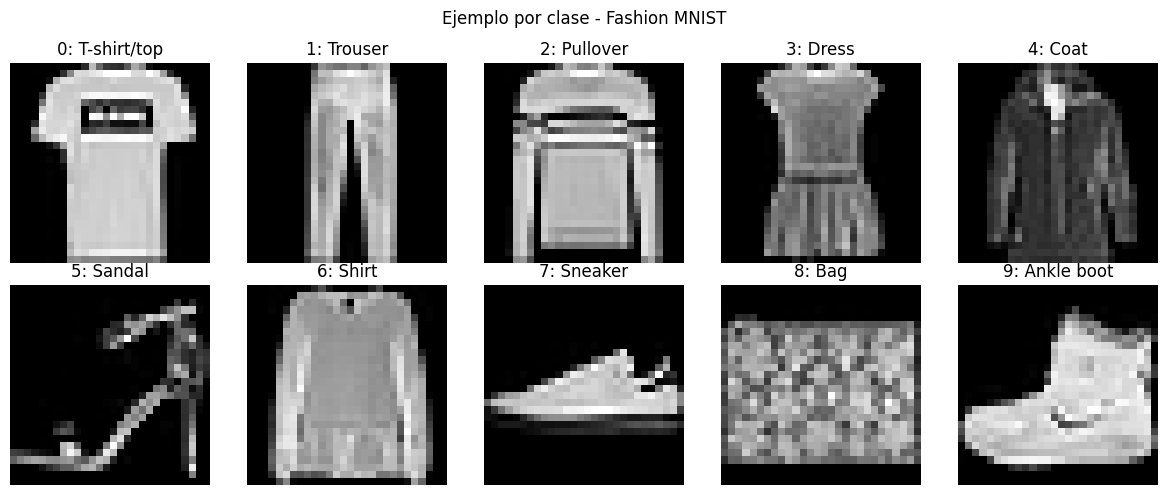

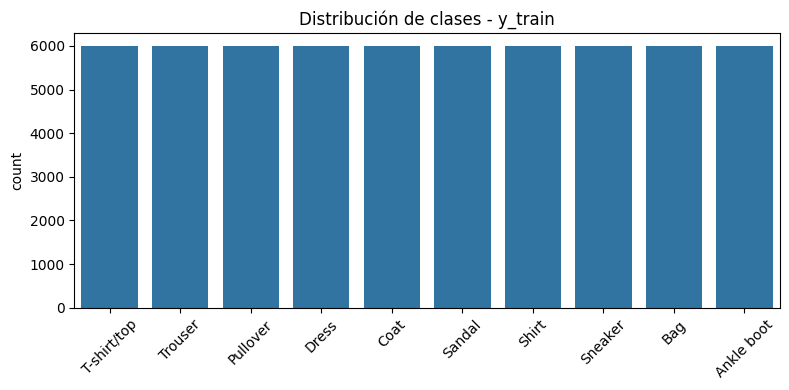

Distribución (label:count):
  0 (T-shirt/top): 6000
  1 (Trouser): 6000
  2 (Pullover): 6000
  3 (Dress): 6000
  4 (Coat): 6000
  5 (Sandal): 6000
  6 (Shirt): 6000
  7 (Sneaker): 6000
  8 (Bag): 6000
  9 (Ankle boot): 6000


In [2]:
# Cargar Fashion-MNIST y mostrar información básica
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Nombres de clases según Fashion-MNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Información básica
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('dtype:', x_train.dtype)
print('min/max:', x_train.min(), x_train.max())
print('Unique labels (train):', np.unique(y_train))

# Mostrar una muestra por cada clase
plt.figure(figsize=(12, 5))
for cls in range(10):
    # Buscar primer índice de la clase en el train
    idx = np.where(y_train == cls)[0][0]
    img = x_train[idx]
    plt.subplot(2, 5, cls + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{cls}: {class_names[cls]}")
    plt.axis('off')
plt.suptitle('Ejemplo por clase - Fashion MNIST')
plt.tight_layout()
plt.show()

# Distribución de clases en el set de entrenamiento
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=y_train)
ax.set_xticks(range(10))
ax.set_xticklabels(class_names, rotation=45)
ax.set_title('Distribución de clases - y_train')
plt.tight_layout()
plt.show()

# Estadísticas adicionales
(unique, counts) = np.unique(y_train, return_counts=True)
print('Distribución (label:count):')
for u, c in zip(unique, counts):
    print(f"  {u} ({class_names[u]}): {c}")


## Parte 2: Algoritmos Clásicos

Implementación específica para este grupo:

- Naive Bayes (GaussianNB) — Implementar y evaluar como baseline.
  - Entrenar con los vectores aplanados.
  - Explorar preprocesados recomendados: escalado (StandardScaler/MinMax), PCA (50–200 componentes) y búsquedas de `var_smoothing`.
  - Evaluar tiempos de entrenamiento y predicción.
  - Generar matriz de confusión y reporte de clasificación.

Se omiten las implementaciones directas de KNN, SVM y Random Forest por alcance de grupo; se pueden mantener notas y celdas comentadas para referencia.

Entregables para esta parte:
- Código entrenando GaussianNB sobre los datos aplanados.
- Matriz de confusión y métricas (accuracy, precision, recall, F1‑score).
- Análisis de preprocesamiento y tiempos.

### Mejoras recomendadas — GaussianNB (baseline)

- Preprocesado: escalar/normalizar las features (StandardScaler o MinMax); eliminar ruido y outliers.
- Reducir dimensionalidad con PCA/TruncatedSVD (50–200 componentes) para quitar redundancia.
- Selección de features (VarianceThreshold, SelectKBest) si hay muchas columnas.
- Ajustes de modelo: explorar `var_smoothing` en log-space (1e-12 → 1e-3) y `fit_prior`/`class_prior`.
- Pipeline: usar Pipeline(Scaler, PCA, GaussianNB) y Grid/RandomSearch con validación estratificada.
- Alternativa: si los features no son gaussianos, probar MultinomialNB/BernoulliNB tras transformar.


Entrenando GaussianNB (baseline clásico)...
GaussianNB test accuracy: 0.5856 (train time 0.23s)


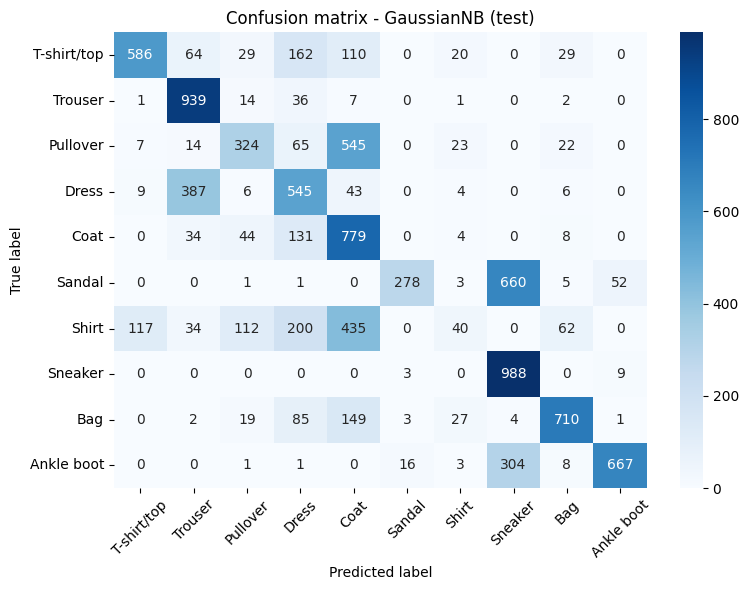

Classification report (test):
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.59      0.68      1000
     Trouser       0.64      0.94      0.76      1000
    Pullover       0.59      0.32      0.42      1000
       Dress       0.44      0.55      0.49      1000
        Coat       0.38      0.78      0.51      1000
      Sandal       0.93      0.28      0.43      1000
       Shirt       0.32      0.04      0.07      1000
     Sneaker       0.51      0.99      0.67      1000
         Bag       0.83      0.71      0.77      1000
  Ankle boot       0.91      0.67      0.77      1000

    accuracy                           0.59     10000
   macro avg       0.64      0.59      0.56     10000
weighted avg       0.64      0.59      0.56     10000



In [3]:
# GaussianNB (baseline) — preprocesado y entrenamiento
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Preprocesado común: normalizar a [0,1]
X_train = x_train.astype(np.float32) / 255.0
X_test = x_test.astype(np.float32) / 255.0

# Aplanar para modelos clásicos
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

print('Entrenando GaussianNB (baseline clásico)...')
start = time.time()
gnb = GaussianNB()
gnb.fit(X_train_flat, y_train)
train_time = time.time() - start

# Evaluación
y_pred_test = gnb.predict(X_test_flat)
acc_test = accuracy_score(y_test, y_pred_test)
print(f'GaussianNB test accuracy: {acc_test:.4f} (train time {train_time:.2f}s)')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Confusion matrix - GaussianNB (test)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

print('Classification report (test):')
print(classification_report(y_test, y_pred_test, target_names=class_names))


## Parte 3: Redes Neuronales

3.1 Red Neuronal Simple (Dense) — 10 pts
- Arquitectura sugerida:
  - Input: 784 neuronas (imágenes aplanadas)
  - Dense 128 + ReLU
  - Dense 64 + ReLU
  - Dense 10 + Softmax
- Usar `categorical_crossentropy` y métricas de accuracy.

3.2 Red Convolucional (CNN) — 20 pts
- Arquitectura sugerida:
  - Conv2D(32, 3x3) + ReLU + MaxPooling
  - Conv2D(64, 3x3) + ReLU + MaxPooling
  - Flatten
  - Dense(128) + ReLU + Dropout(0.5)
  - Dense(10) + Softmax
- Aplicar data augmentation como bonus opcional.

Entregables:
- Implementación de ambas redes.
- Gráficas de loss y accuracy durante entrenamiento.
- Evaluación en el conjunto de prueba y análisis de overfitting/underfitting.

### Mejoras recomendadas — Dense (MLP)

- Preprocesado: mantener normalización (0–1) o usar StandardScaler; considerar reusar imágenes en formato 2D para augmentación.
- Arquitectura: experimentar con más capas/unidades (ej. 256→128→64), BatchNorm y activaciones modernas (ReLU/Swish).
- Regularización: Dropout (0.2–0.5), L2 weight decay (1e-4–1e-2) y BatchNorm entre capas.
- Optimización: ajustar learning_rate (1e-4–1e-2), probar Adam y SGD+momentum; usar ReduceLROnPlateau.
- Entrenamiento: early stopping, checkpoints, probar batch sizes 64–256, y monitorizar curvas train/val.
- Búsqueda de hiperparámetros: RandomizedSearch/Optuna para lr, layers, units, dropout, l2, batch_size.
- Diagnóstico: matriz de confusión y curvas de aprendizaje para detectar under/overfitting.


In [4]:
# Construir modelo Dense (MLP)
def build_simple_dense_model(input_shape=(784,), num_classes=10, compile_model=True, learning_rate=1e-3):
    """Builds a simple MLP:
    Input -> Dense(128, relu) -> Dense(64, relu) -> Dense(num_classes, softmax)

    Args:
        input_shape (tuple): shape of the input (e.g., (784,)).
        num_classes (int): number of output classes.
        compile_model (bool): whether to compile the model before returning.
        learning_rate (float): Adam optimizer learning rate.

    Returns:
        tf.keras.Model: the constructed (and optionally compiled) model.
    """
    from keras import layers, models, optimizers

    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    if compile_model:
        model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model



Entrenando modelo Dense (MLP) con callbacks...
Epoch 1/20


422/422 - 1s - 3ms/step - accuracy: 0.8064 - loss: 0.5619 - val_accuracy: 0.8500 - val_loss: 0.4124
Epoch 2/20


422/422 - 1s - 2ms/step - accuracy: 0.8583 - loss: 0.3948 - val_accuracy: 0.8698 - val_loss: 0.3761
Epoch 3/20


422/422 - 1s - 2ms/step - accuracy: 0.8716 - loss: 0.3560 - val_accuracy: 0.8717 - val_loss: 0.3558
Epoch 4/20


422/422 - 1s - 2ms/step - accuracy: 0.8811 - loss: 0.3273 - val_accuracy: 0.8743 - val_loss: 0.3539
Epoch 5/20


422/422 - 1s - 2ms/step - accuracy: 0.8874 - loss: 0.3099 - val_accuracy: 0.8787 - val_loss: 0.3393
Epoch 6/20


422/422 - 1s - 2ms/step - accuracy: 0.8937 - loss: 0.2928 - val_accuracy: 0.8788 - val_loss: 0.3295
Epoch 7/20


422/422 - 1s - 2ms/step - accuracy: 0.8972 - loss: 0.2815 - val_accuracy: 0.8852 - val_loss: 0.3240
Epoch 8/20
422/422 - 1s - 2ms/step - accuracy: 0.8998 - loss: 0.2708 - val_accuracy: 0.8813 - val_loss: 0.3275
Epoch 9/20
422/422 - 1s - 2ms/step - accuracy: 0.9019 - loss: 0.2631 - val_accuracy: 0.8833 - val_loss: 0.3243
Epoch 10/20
422/422 - 1s - 2ms/step - accuracy: 0.9077 - loss: 0.2508 - val_accuracy: 0.8843 - val_loss: 0.3366
Dense test accuracy (evaluate): 0.8786
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
Dense test accuracy (from preds): 0.8786


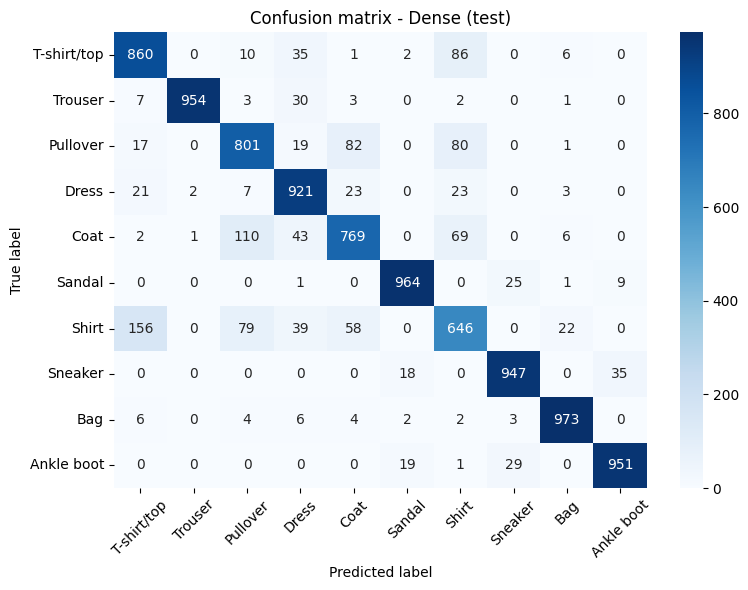

Classification report (test) - Dense:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.86      0.83      1000
     Trouser       1.00      0.95      0.97      1000
    Pullover       0.79      0.80      0.80      1000
       Dress       0.84      0.92      0.88      1000
        Coat       0.82      0.77      0.79      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.71      0.65      0.68      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



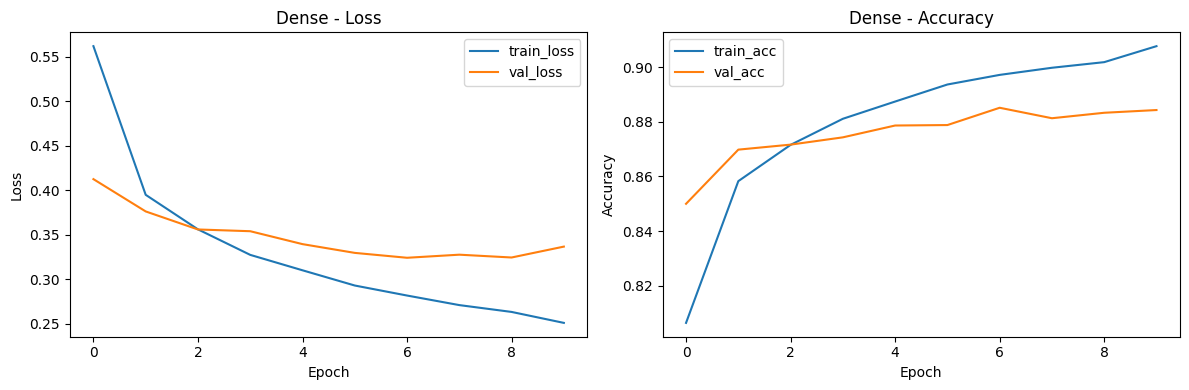

In [5]:
# Dense (MLP) — entrenamiento y evaluación (con callbacks + métricas completas)
from keras.callbacks import EarlyStopping, ModelCheckpoint
print('\nEntrenando modelo Dense (MLP) con callbacks...')

# Preparar datos aplanados (ya normalizados en la celda GaussianNB)
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Construir y compilar el modelo
model_dense = build_simple_dense_model(input_shape=(784,), num_classes=10, compile_model=True)

callbacks_dense = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('dense_best.h5', save_best_only=True)
]

# Entrenamiento
history_dense = model_dense.fit(X_train_flat, y_train,
                              epochs=20,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=callbacks_dense,
                              verbose=2)

# Evaluación con evaluate
loss_d, acc_d = model_dense.evaluate(X_test_flat, y_test, verbose=0)
print(f'Dense test accuracy (evaluate): {acc_d:.4f}')

# Guardar history en resultados
results = globals().get('results', {})
results['dense'] = {'test_acc': acc_d, 'history': history_dense.history}
globals()['results'] = results

# ---------- Métricas adicionales: predicciones, matriz de confusión, reporte de clasificación ----------
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predicciones del modelo (argmax sobre probabilidades)
y_pred_dense = model_dense.predict(X_test_flat).argmax(axis=1)
acc_from_preds = accuracy_score(y_test, y_pred_dense)
print(f'Dense test accuracy (from preds): {acc_from_preds:.4f}')

# Matriz de confusión
cm_dense = confusion_matrix(y_test, y_pred_dense)
plt.figure(figsize=(8,6))
sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Confusion matrix - Dense (test)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print('Classification report (test) - Dense:')
print(classification_report(y_test, y_pred_dense, target_names=class_names))

# ---------- Curvas de entrenamiento (loss / accuracy) ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_dense.history.get('loss', []), label='train_loss')
plt.plot(history_dense.history.get('val_loss', []), label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Dense - Loss')

plt.subplot(1,2,2)
# Keras may use 'accuracy' or 'acc' depending on version
acc_key = 'accuracy' if 'accuracy' in history_dense.history else 'acc'
val_acc_key = 'val_' + acc_key
plt.plot(history_dense.history.get(acc_key, []), label='train_acc')
plt.plot(history_dense.history.get(val_acc_key, []), label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Dense - Accuracy')
plt.tight_layout()
plt.show()


### Mejoras recomendadas — CNN

- Preprocesado y augmentación: aplicar data augmentation (rotations, shifts, zoom, horizontal flip) usando `ImageDataGenerator` o `tf.keras.layers.Random*` para aumentar la robustez; probar normalización por canal (mean/std) o `StandardScaler` si procede.
- Arquitectura: experimentar con bloques convolucionales más profundos (ej. 3–4 bloques), cambiar filtros (32→64→128), usar convoluciones separables (`SeparableConv2D`) para eficiencia, y probar `GlobalAveragePooling2D` en lugar de `Flatten`.
- Regularización: usar BatchNormalization tras convoluciones, Dropout en el clasificador (0.2–0.5), y L2 weight decay (1e-4–1e-2) en capas densas/convolucionales.
- Optimización y scheduler: probar optimizadores (AdamW, RMSprop, SGD+momentum) y schedulers como `ReduceLROnPlateau`, `CosineAnnealing` o `ExponentialDecay` para lr; usar warmup si se entrena con lr altos.
- Augmented training setups: entrenamiento con mixup/cutmix, label smoothing y entrenamiento con batch normalization en modo correcto (no congelar en train).
- Hyperparameter search: usar Optuna/keras-tuner para explorar lr, batch_size, number of filters, kernel_size, dropout, weight decay y augmentation params.
- Transfer learning: probar modelos preentrenados (MobileNetV2, EfficientNet-lite) con fine-tuning si el dominio es cercano y los recursos lo permiten; usar `include_top=False` + custom head.
- Batch size y batch norm: experimentar con batch sizes mayores si la memoria lo permite; cuando use BatchNorm, ajustar lr y batch_size conjuntamente.
- Early stopping & checkpoints: mantener EarlyStopping y ModelCheckpoint (guardar mejores pesos); además, considerar guardar checkpoints por epoca para reanudar búsquedas largas.
- Evaluación y diagnóstico: usar augmentación en test-time (TTA) para robustez, analizar matriz de confusión por clase, curvas ROC/PR por clase si aplica, y grad-CAM/saliency para inspeccionar decisiones del modelo.
- Optimización para despliegue: cuantización (post-training quantization), pruning y versiones ligeras (MobileNet/TF-Lite) si necesita desplegar en dispositivos con recursos limitados.


In [6]:
# Construir modelo CNN
def build_cnn_model(input_shape=(28,28,1), num_classes=10, compile_model=True, learning_rate=1e-3, dropout_rate=0.5):
    """Builds a simple CNN:
    Conv2D(32,3x3)+ReLU+MaxPool -> Conv2D(64,3x3)+ReLU+MaxPool -> Flatten -> Dense(128)+ReLU -> Dropout -> Dense(num_classes, softmax)

    Args:
        input_shape (tuple): shape for the image input, e.g. (28,28,1).
        num_classes (int): number of output classes.
        compile_model (bool): whether to compile before returning.
        learning_rate (float): Adam learning rate.
        dropout_rate (float): dropout rate after dense.

    Returns:
        tf.keras.Model
    """
    from keras import layers, models, optimizers

    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # Bloque 1
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))

    # Bloque 2
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))

    # Clasificador
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    if compile_model:
        model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# Ejemplo de uso (comentar si no quiere ejecutarlo ahora):
# cnn = build_cnn_model()
# cnn.summary()



Entrenando CNN con callbacks...
Epoch 1/20


422/422 - 10s - 23ms/step - accuracy: 0.7871 - loss: 0.6019 - val_accuracy: 0.8705 - val_loss: 0.3622
Epoch 2/20


422/422 - 8s - 20ms/step - accuracy: 0.8650 - loss: 0.3803 - val_accuracy: 0.8815 - val_loss: 0.3076
Epoch 3/20


422/422 - 9s - 20ms/step - accuracy: 0.8836 - loss: 0.3237 - val_accuracy: 0.8925 - val_loss: 0.2838
Epoch 4/20


422/422 - 8s - 20ms/step - accuracy: 0.8952 - loss: 0.2934 - val_accuracy: 0.8992 - val_loss: 0.2573
Epoch 5/20


422/422 - 8s - 20ms/step - accuracy: 0.9020 - loss: 0.2701 - val_accuracy: 0.9063 - val_loss: 0.2479
Epoch 6/20


422/422 - 9s - 21ms/step - accuracy: 0.9085 - loss: 0.2520 - val_accuracy: 0.9127 - val_loss: 0.2346
Epoch 7/20


422/422 - 9s - 20ms/step - accuracy: 0.9155 - loss: 0.2356 - val_accuracy: 0.9123 - val_loss: 0.2318
Epoch 8/20


422/422 - 9s - 21ms/step - accuracy: 0.9204 - loss: 0.2192 - val_accuracy: 0.9182 - val_loss: 0.2184
Epoch 9/20
422/422 - 9s - 21ms/step - accuracy: 0.9217 - loss: 0.2116 - val_accuracy: 0.9152 - val_loss: 0.2208
Epoch 10/20


422/422 - 9s - 22ms/step - accuracy: 0.9282 - loss: 0.1980 - val_accuracy: 0.9203 - val_loss: 0.2158
Epoch 11/20
422/422 - 9s - 22ms/step - accuracy: 0.9312 - loss: 0.1880 - val_accuracy: 0.9218 - val_loss: 0.2208
Epoch 12/20
422/422 - 9s - 21ms/step - accuracy: 0.9352 - loss: 0.1775 - val_accuracy: 0.9207 - val_loss: 0.2218
Epoch 13/20
422/422 - 9s - 21ms/step - accuracy: 0.9380 - loss: 0.1664 - val_accuracy: 0.9202 - val_loss: 0.2198
CNN test accuracy (evaluate): 0.9178
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN test accuracy (from preds): 0.9178


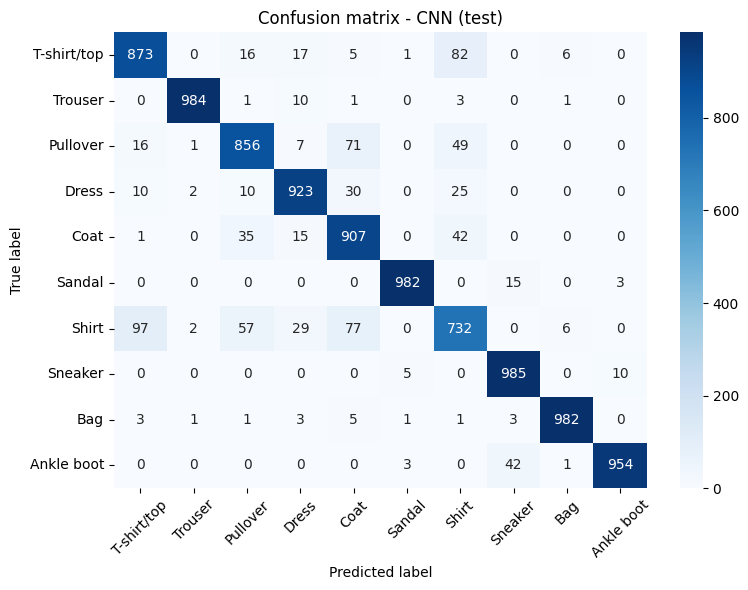

Classification report (test) - CNN:
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.87      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.88      0.86      0.87      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.83      0.91      0.87      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.78      0.73      0.76      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



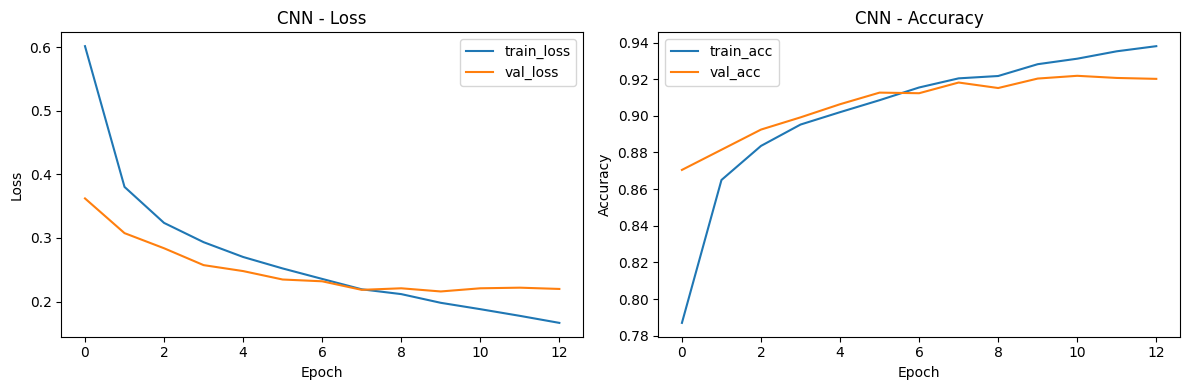

In [7]:
# CNN — entrenamiento y evaluación (con callbacks + métricas completas)
from keras.callbacks import EarlyStopping, ModelCheckpoint
print('\nEntrenando CNN con callbacks...')

# Preparar datos para CNN (ya normalizados en la celda GaussianNB)
X_train_cnn = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test_cnn = X_test.reshape((X_test.shape[0], 28, 28, 1))

cnn = build_cnn_model(input_shape=(28,28,1), num_classes=10, compile_model=True)

callbacks_cnn = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('cnn_best.h5', save_best_only=True)
]

history_cnn = cnn.fit(X_train_cnn, y_train,
                      epochs=20,
                      batch_size=128,
                      validation_split=0.1,
                      callbacks=callbacks_cnn,
                      verbose=2)

# Evaluación con evaluate
loss_c, acc_c = cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f'CNN test accuracy (evaluate): {acc_c:.4f}')

# Guardar history
results = globals().get('results', {})
results['cnn'] = {'test_acc': acc_c, 'history': history_cnn.history}
globals()['results'] = results

# ---------- Métricas adicionales: predicciones, matriz de confusión, reporte de clasificación ----------
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predicciones del modelo (argmax sobre probabilidades)
y_pred_cnn = cnn.predict(X_test_cnn).argmax(axis=1)
acc_from_preds = accuracy_score(y_test, y_pred_cnn)
print(f'CNN test accuracy (from preds): {acc_from_preds:.4f}')

# Matriz de confusión
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Confusion matrix - CNN (test)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print('Classification report (test) - CNN:')
print(classification_report(y_test, y_pred_cnn, target_names=class_names))

# ---------- Curvas de entrenamiento (loss / accuracy) ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history.get('loss', []), label='train_loss')
plt.plot(history_cnn.history.get('val_loss', []), label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN - Loss')

plt.subplot(1,2,2)
acc_key = 'accuracy' if 'accuracy' in history_cnn.history else 'acc'
val_acc_key = 'val_' + acc_key
plt.plot(history_cnn.history.get(acc_key, []), label='train_acc')
plt.plot(history_cnn.history.get(val_acc_key, []), label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN - Accuracy')
plt.tight_layout()
plt.show()
